# Problem wieloagentowy

### Autorzy:

Diana Misiaczyńska,
Emilia Myrta

Tematyką szóstego, i tym samym ostatniego, projektu są problemy wieloagentowe. Środowisko, które wybrałyśmy to `Simple Reference` z `PettingZoo`. Jest ono cześcią nastawionego na komunikację agentów zestawu `Multi Particle Environments (MPE)`.

Wybranym przez nas algorytmem rozwiązującym problem jest `DQN` z biblioteki `stable_baselines3`.

In [28]:
from pettingzoo.mpe import simple_reference_v3

In [29]:
env = simple_reference_v3.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample()

    env.step(action)
env.close()

Dodajemy wszystkie potrzebne importy.

In [30]:
import supersuit as ss
from stable_baselines3 import DQN
from pettingzoo.mpe import simple_reference_v3
from pettingzoo.utils.conversions import aec_to_parallel
import matplotlib.pyplot as plt
import numpy as np

Inicjalizujemy środowisko PettingZoo i konwertujemy do ParallelEnv. Następnie korzystamy z wrapperów supersuit do wyrównania przestrzeni obserwacji i akcji. Potrzebna jest także konwersja środowiska do formatu kompatybilnego z Gym.

In [31]:
env = simple_reference_v3.env()
parallel_env = aec_to_parallel(env)

parallel_env = ss.pad_observations_v0(parallel_env)
parallel_env = ss.pad_action_space_v0(parallel_env)

env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
env = ss.concat_vec_envs_v1(env, 4, num_cpus=1, base_class="stable_baselines3")

Dostosowujemy hiperparametry modelu DQN oraz ustawiamy liczbę timesteps na 10 000.

In [32]:
model = DQN('MlpPolicy', env, verbose=1,
            learning_rate=1e-3,
            gamma=0.99,
            exploration_fraction=0.1,
            exploration_final_eps=0.01,
            target_update_interval=1000,
            train_freq=1,
            gradient_steps=1,
            batch_size=32,
            buffer_size=100000)

model.learn(total_timesteps=10000)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1668     |
|    time_elapsed     | 0        |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.453    |
|    n_updates        | 12       |
----------------------------------
-----------------------------
| time/              |      |
|    episodes        | 8    |
|    fps             | 1655 |
|    time_elapsed    | 0    |
|    total_timesteps | 200  |
-----------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 1521     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
| train/              |          |
|  

Następnie testujemy wytrenowany model. Oprócz tego wygładzamy wyniki za pomocą średniej kroczącej.


In [33]:
obs = env.reset()
total_rewards = []
num_episodes = 1000
for i in range(num_episodes):
    total_reward = 0
    done = [False for _ in range(env.num_envs)]
    while not all(done):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        total_reward += sum(rewards)
    total_rewards.append(total_reward)

env.close()

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
smoothed_rewards = moving_average(total_rewards, window_size)

Na koniec wizualizacjemy krzywą uczenia.

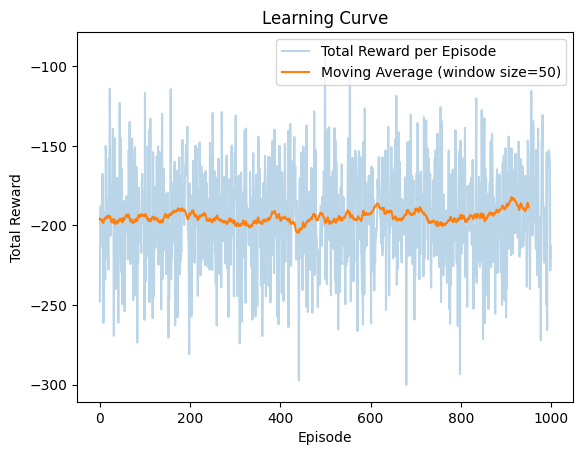

In [34]:
plt.plot(total_rewards, alpha=0.3, label='Total Reward per Episode')
plt.plot(smoothed_rewards, label=f'Moving Average (window size={window_size})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()